In [1]:
import sys
sys.path.append('../../build')
import cv2 as cv
import numpy as np
import libry as ry
import time
import math
# from perception import find_ball
#print(cv.__version__)

In [2]:
from environment import *
env = Environment(ry, math, np, time)

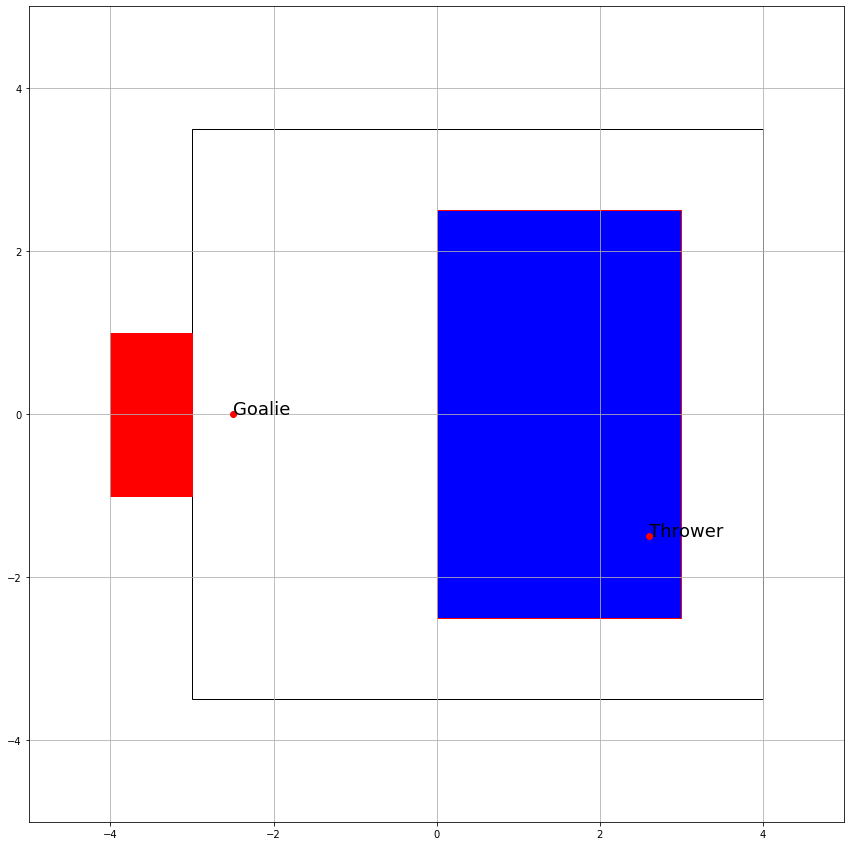

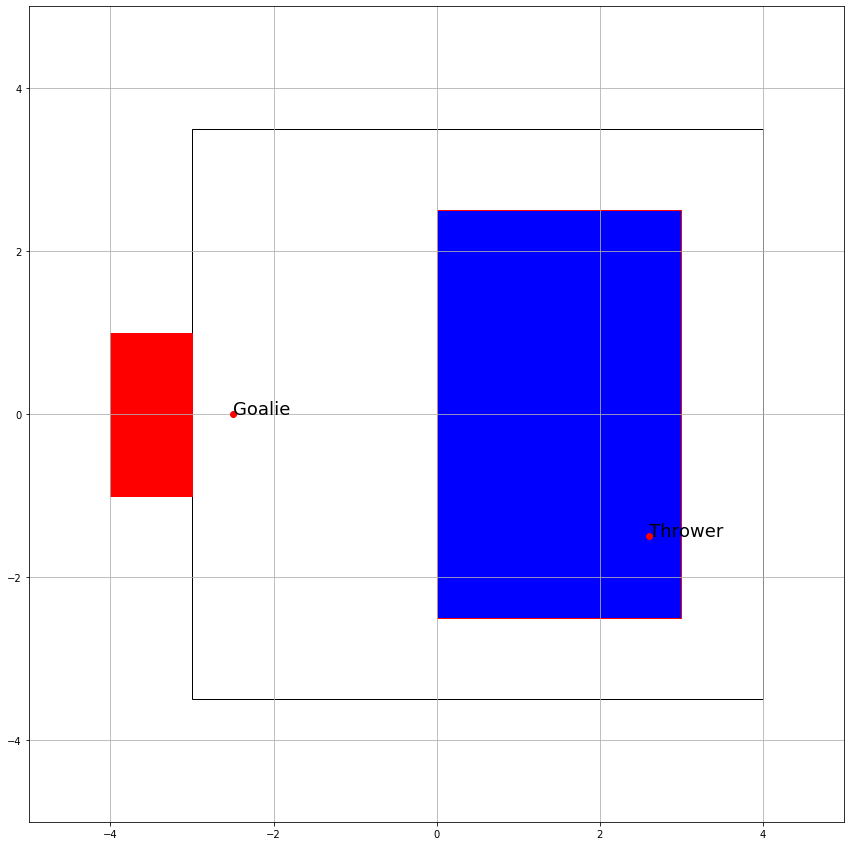

OK 2.6 -1.5
Picking up the ball
Grasping the ball
Lift the ball
Throwing the ball
Overriding the move_to and grab objectives...
Stopping the ball
Resetting to initial pose
Done


In [3]:
#Environment initialization
env.start()

# Start gui
posx, posy = thrower_gui(env, 0)

# Move to the position
env.move_thrower(0, [float(posx), float(posy)])

# Spawn Ball
env.spawn_ball()

# Throw and block
env.throw_and_block()